In [1]:
from aesthetic.plot import set_style, savefig
set_style("science")

In [3]:
import sys

sys.path.insert(0, "../toi6251/")
from utils import get_exofop_json, plot_archival_images, get_dss_data

In [19]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, Distance

target = "Speculoos-3"

#http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%404021340&Name=LSPM%20J2049%2b3336&submit=submit
hms = "20 49 27.4405195157"
dms = "+33 36 50.968630035"
pmra = -207.809*u.mas/u.yr
pmdec = -412.215*u.mas/u.yr
rv = 17.815800*u.km/u.second
distance = Distance(parallax=59.7005*u.mas)
ra, dec, pmra, pmdec, distance, rv

c = SkyCoord(f"{hms} {dms}",
             unit=("hourangle", "degree"),
             distance=distance,
             pm_ra_cosdec=pmra, 
             pm_dec=pmdec,
             radial_velocity=rv,
             frame='icrs',
             obstime='J2000')

In [20]:
ra = c2023.ra.deg
dec = c2023.dec.deg
ra, dec

(312.36269484442613, 33.6114476093065)

In [15]:
import numpy as np
pm = np.hypot(pmra, pmdec) #mas/yr
baseline_year = 70
offset = pm*baseline_year/1e3
offset

<Quantity 32.31436762 mas / yr>

## arhival and muscat3

Set OBSGEO-B to    20.706900 from OBSGEO-[XYZ].
Set OBSGEO-H to     3047.597 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


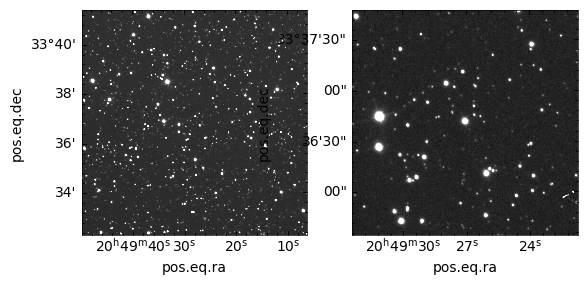

In [16]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
import matplotlib.pyplot as pl

from astropy.visualization import ZScaleInterval
interval = ZScaleInterval(contrast=0.1)

fp = "./data/ogg2m001-ep05-20230902-0085-e91.fits"
hdu2 = fits.open(fp)[0]
# zmin, zmax = interval.get_limits(hdu2.data)
# pl.imshow(hdu2.data, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')

def crop_data(hdu2, position, rad_arcsec=300):
    wcs = WCS(hdu2.header)
    coords = wcs.all_world2pix(np.c_[position], 0)
    xpix, ypix = int(coords[0][0]), int(coords[0][1])
    
    pixscale = hdu2.header['PIXSCALE']
    dx = dy = round(rad_arcsec)

    dcrop = hdu2.data[ypix-dy:ypix+dy,xpix-dx:xpix+dx]
    wcscrop = wcs[ypix-dy:ypix+dy,xpix-dx:xpix+dx]
    return dcrop, wcscrop

fig = pl.figure()
ax = fig.add_subplot(121, projection=WCS(hdu2.header))

zmin, zmax = interval.get_limits(hdu2.data)
ax.imshow(hdu2.data, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')


dcrop, wcscrop = crop_data(hdu2, (ra,dec), rad_arcsec=250)
ax = fig.add_subplot(122, projection=wcscrop)
zmin, zmax = interval.get_limits(dcrop)
ax.imshow(dcrop, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')

In [21]:
c2023 = c.apply_space_motion(new_obstime=Time(hdu2.header['DATE-OBS']))
np.sqrt((ra-c2023.ra.deg)**2+(dec-c2023.dec.deg)**2)*60*60

5.747383799802208e-05

In [45]:
#2023-(2023-1951)//2 = 1986
c1987 = c.apply_space_motion(new_obstime=Time("1987-06-01 00:00"))
c1987

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (312.36520801, 33.61559926, 16.75004917)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-207.81816571, -412.2245357, 17.81476741)>

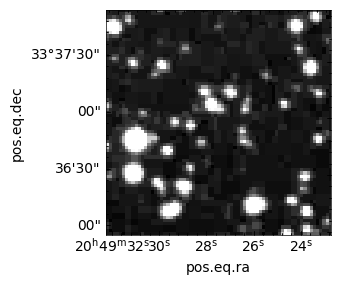

In [46]:
cmap = "gray"
survey="poss1_red"
epoch="J2015.5"
height=2
width=2
base_url = "http://archive.stsci.edu/cgi-bin/dss_search?v="
url = f"{base_url}{survey}&r={c1987.ra.deg}&d={c1987.dec.deg}&e={epoch}&h={height}&w={width}&f=fits&c=none&s=on&fov=NONE&v3"
hdulist = fits.open(url)
hdu1 = hdulist[0]

fig = pl.figure()
ax = fig.add_subplot(121, projection=WCS(hdu1.header))
zmin, zmax = interval.get_limits(hdu1.data)
ax.imshow(hdu1.data, origin="lower", vmin=zmin, vmax=zmax, cmap=cmap)

In [48]:
#time in header is weird: 62mins?
hdu1.header['DATE-OBS']

'1951-07-12T09:62:00'

In [49]:
#update header with a more reasonable time
hdu1.header['DATE-OBS'] = '1951-07-12T10:02:00.00'

In [50]:
c1951 = c.apply_space_motion(new_obstime=Time(hdu1.header['DATE-OBS']))
np.sqrt((ra-c1951.ra.deg)**2+(dec-c1951.dec.deg)**2)*60*60

/home/jp/miniconda3/envs/wakai/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jp/miniconda3/envs/wakai/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jp/miniconda3/envs/wakai/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


34.764753715520854

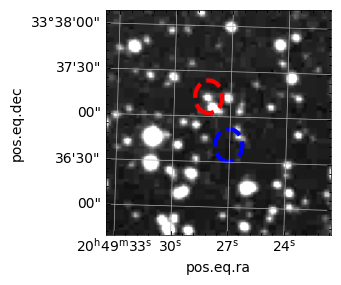

In [83]:
from matplotlib.patches import Circle

fig = pl.figure()
ax = fig.add_subplot(121, projection=WCS(hdu1.header))
zmin, zmax = interval.get_limits(hdu1.data)
ax.imshow(hdu1.data, origin="lower", vmin=zmin, vmax=zmax, cmap=cmap)

dr,dd = -1/3600, 2/3600
c1 = Circle((c1951.ra.deg+dr, c1951.dec.deg+dd), 
            0.003, edgecolor='r', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c1);
c2 = Circle((c2023.ra.deg, c2023.dec.deg), 
            0.003, edgecolor='b', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c2);
ax.grid(True)

Set OBSGEO-B to    20.706900 from OBSGEO-[XYZ].
Set OBSGEO-H to     3047.597 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


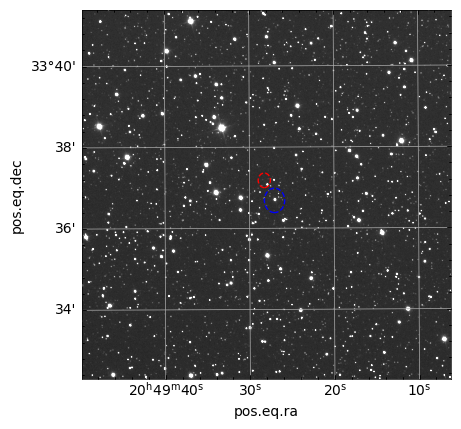

In [52]:
fig = pl.figure()

ax = fig.add_subplot(projection=WCS(hdu2.header))

zmin, zmax = interval.get_limits(hdu2.data)
ax.imshow(hdu2.data, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')

c1 = Circle((c1951.ra.deg, c1951.dec.deg), 
            0.003, edgecolor='r', facecolor='none',
            lw=1, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c1);
c2 = Circle((c2023.ra.deg, c2023.dec.deg), 
            0.005, edgecolor='b', facecolor='none',
            lw=1, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c2);
ax.grid(True)

Set OBSGEO-B to    20.706900 from OBSGEO-[XYZ].
Set OBSGEO-H to     3047.597 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


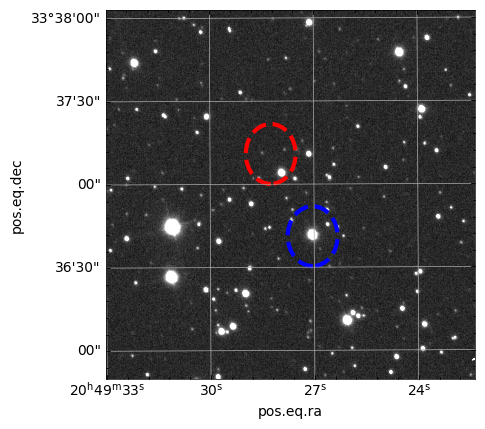

In [84]:
fig = pl.figure()

dcrop, wcscrop = crop_data(hdu2, (c1986.ra.deg, c1986.dec.deg), rad_arcsec=250)
ax = fig.add_subplot(projection=wcscrop)

zmin, zmax = interval.get_limits(dcrop)
ax.imshow(dcrop, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')

c1 = Circle((c1951.ra.deg, c1951.dec.deg), 
            0.003, edgecolor='r', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c1);
c2 = Circle((c2023.ra.deg, c2023.dec.deg), 
            0.003, edgecolor='b', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c2);
ax.grid(True)

Set OBSGEO-B to    20.706900 from OBSGEO-[XYZ].
Set OBSGEO-H to     3047.597 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


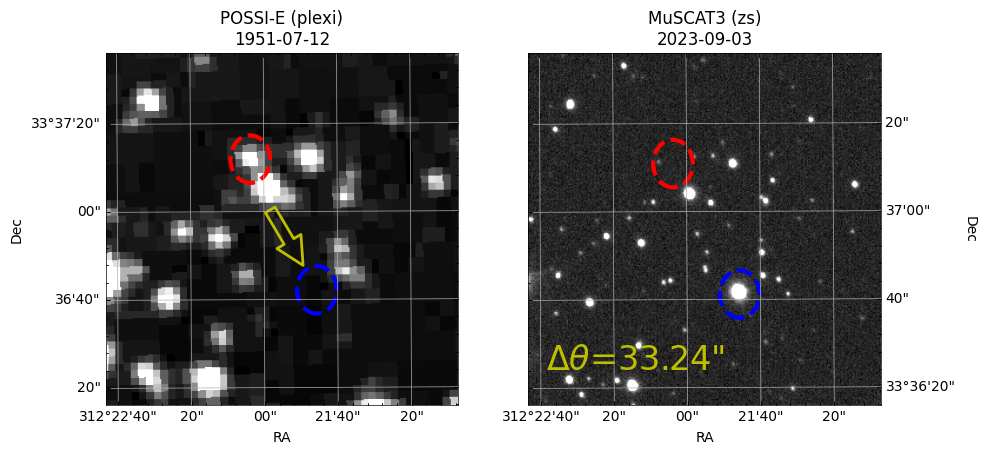

In [167]:
from reproject import reproject_interp, reproject_adaptive
from astropy.visualization import ZScaleInterval
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as pl
from matplotlib.patches import Circle, FancyArrowPatch

interval = ZScaleInterval(contrast=0.1)

cmap = "gray"
survey="poss1_red"
epoch="J2015.5"
height=2.5 #arcmin
width=2.5
base_url = "http://archive.stsci.edu/cgi-bin/dss_search?v="
url = f"{base_url}{survey}&r={c1987.ra.deg}&d={c1987.dec.deg}&e={epoch}&h={height}&w={width}&f=fits&c=none&s=on&fov=NONE&v3"
hdulist = fits.open(url)
hdu1 = hdulist[0]

#update header
hdu1.header['DATE-OBS'] = '1951-07-12T10:02:00.00'

fp = "./data/ogg2m001-ep05-20230902-0085-e91.fits"
hdu2 = fits.open(fp)[0]

dcrop, wcscrop = crop_data(hdu2, (c1987.ra.deg, c1987.dec.deg), rad_arcsec=height*60)

projected_img, footprint = reproject_interp(hdu1, 
                                            wcscrop, 
                                            order='nearest-neighbor',
                                           )

fig = pl.figure(figsize=(10, 5), constrained_layout=False)

ax = fig.add_subplot(121, projection=wcscrop)
zmin, zmax = interval.get_limits(projected_img)
ax.imshow(projected_img, origin="lower", vmin=zmin, vmax=zmax, cmap=cmap)

crad = 0.0015
dd = 1/3600
c1 = Circle((c1951.ra.deg, c1951.dec.deg+dd), 
            crad, edgecolor='r', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c1);
c2 = Circle((c2023.ra.deg, c2023.dec.deg+dd), 
            crad, edgecolor='b', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c2);
ax.grid(True)


coord_format="dd:mm:ss"
ax.coords[1].set_major_formatter(coord_format)
ax.coords[0].set_major_formatter(coord_format)
ax.set_ylabel("Dec")
ax.set_xlabel("RA")

filt1 = (
        hdu1.header["FILTER"]
        if hdu1.header["FILTER"] is not None
        else survey1.split("_")[1]
    )
title = f"{hdu1.header['SURVEY']} ({filt1})\n"
title += f"{hdu1.header['DATE-OBS'][:10]}"
ax.set_title(title)

ax = fig.add_subplot(122, projection=wcscrop)

zmin, zmax = interval.get_limits(dcrop)
ax.imshow(dcrop, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')

c1 = Circle((c1951.ra.deg, c1951.dec.deg), 
            crad, edgecolor='r', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c1);
c2 = Circle((c2023.ra.deg, c2023.dec.deg), 
            crad, edgecolor='b', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c2);
ax.grid(True)

ax.coords[1].set_major_formatter(coord_format)
ax.coords[0].set_major_formatter(coord_format)
ax.coords["dec"].set_axislabel_position("r")
ax.coords["dec"].set_ticklabel_position("r")
ax.coords["dec"].set_axislabel("Dec")
ax.set_xlabel("RA")

filt2 = hdu2.header
title = f"MuSCAT3 ({hdu2.header['FILTER1']})\n"
title += f"{hdu2.header['DATE-OBS'][:10]}"
ax.set_title(title)

color = 'y'
baseline = int(hdu2.header["DATE-OBS"][:4]) - int(hdu1.header["DATE-OBS"][:4])
pm = np.hypot(pmra, pmdec) #mas/yr
offset = (pm*baseline*u.yr).to(u.arcsec)
text = r"$\Delta \theta$="+f"{offset.value:.2f}\""
ax.text(0.05, 0.1, text, transform=ax.transAxes, c=color, fontsize=24);

add_arrow = True
ax = fig.axes[0]
if add_arrow:
    x_tail = c1951.ra.deg
    y_tail = c1951.dec.deg
    x_head = c2023.ra.deg+dr
    y_head = c2023.dec.deg+dd
    dx = x_head - x_tail
    dy = y_head - y_tail

    offset = -10/3600
    a = FancyArrowPatch((x_tail+offset/2, y_tail+offset), 
                        (x_head-offset/3, y_head-offset/2),
                        mutation_scale=40,
                        edgecolor=color, 
                        facecolor='None', 
                        lw=2, 
                        arrowstyle='simple',
                        transform=ax.get_transform('fk5')
                       )
    ax.add_patch(a);


In [168]:
outpath="./archival_imaging.png"
savefig(fig, outpath, dpi=400, writepdf=False)

2023-11-20T08:39:57.057964: made ./archival_imaging.png


In [172]:
(pm*baseline*u.yr).to(u.arcsec)

<Quantity 33.23763527 arcsec>